In [32]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  TODO:

# Offset reconstruction 

### Reconstruction of an apple measured with offset detector.

Apple measured with lab-Xray CT machine where the detector was offset in order to image the entire sample in the tomography.  We scanned the apple, which was too wide for the regular beam, in offset mode, where the fan only covers a bit more than half of the apple width, and due to offsetting the rotation centre to the side, the other half of the apple will rotate into the fan and as such full data will be recorded.   The default reconstruction done by the table top CT machine did not support this, so we used CIL to set up the offset geometry. This notebook showcases three different reconstructions of this sample, one using the filtered-back-projection and two using iterative methods.

### CIL Version 23.1.0

In [33]:
import cil
print(cil.__version__)

23.1.0


In [52]:
import numpy as np
import os
import matplotlib.pyplot as plt

from cil.io import TIFFStackReader
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, Slicer, Padder
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show_geometry
from cil.framework import AcquisitionGeometry, ImageGeometry

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA
from cil.optimisation.functions import IndicatorBox,  LeastSquares, TotalVariation

# Import from CIL ASTRA plugin
from cil.plugins.astra.processors import FBP, AstraBackProjector3D
from cil.plugins.astra.operators import ProjectionOperator

### Reading the data

We define the geometry of the system. 

In [35]:
# Define cone geometry variables
SOD = 355 # mm
SDD = 398 # mm
COR = -100 # number of pixels from the edge of the center
pixel_size = 0.048 # mm
image_pixel_size = 0.096 # mm

angles_arr = np.linspace(0, 2*np.pi, 200)

In [36]:
# create AcquisitionGeometry
ag = AcquisitionGeometry.create_Cone3D(
    source_position=[0.0, -SOD, 0.0],
    detector_position=[COR*pixel_size, SDD-SOD, 0.0],
    rotation_axis_position=[0, 0*pixel_size, 0.0],
    rotation_axis_direction=[0., 0., 1.0]
)
ag.set_angles(angles=angles_arr, angle_unit='radian' )
ag.set_panel(num_pixels=[500, 500], pixel_size=pixel_size, origin='top-left') 

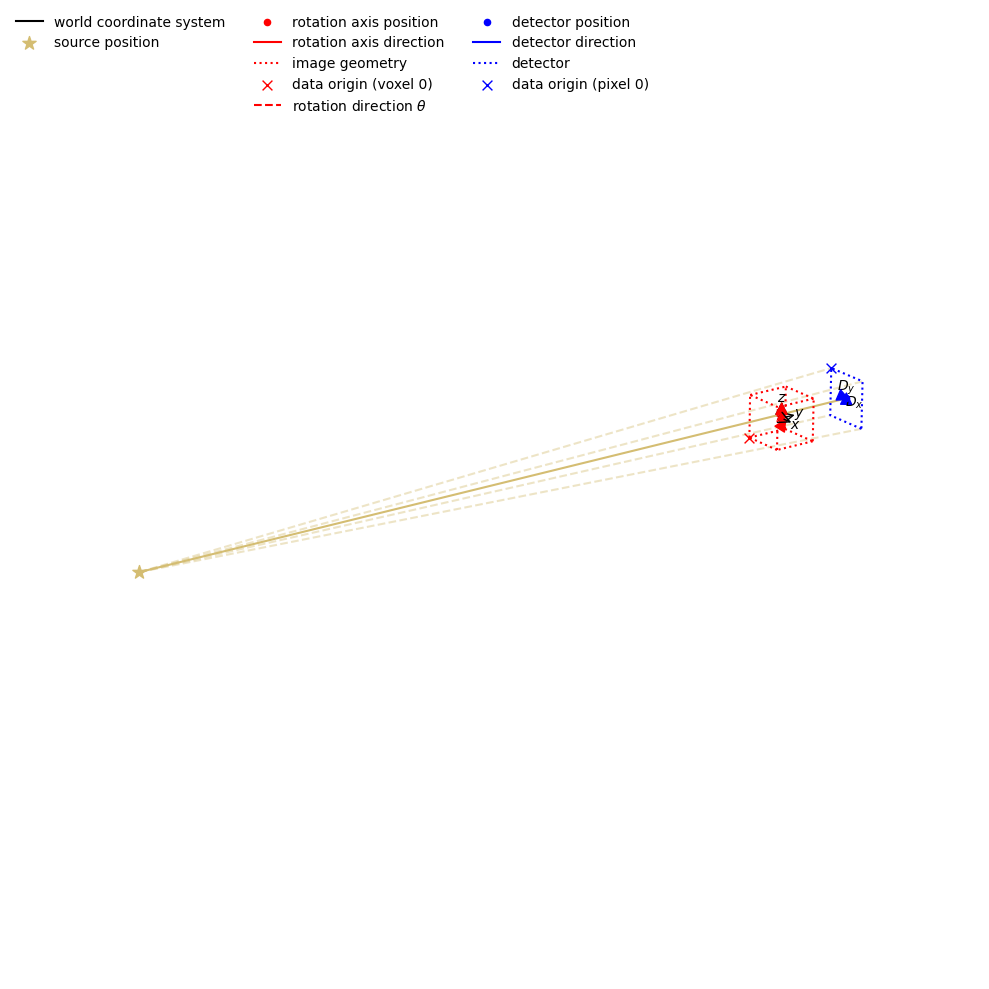

In [37]:
show_geometry(ag, view_distance=5)

### The Dataset

This requires the dataset `apple.zip` from [link]
Please download the data and update the 'proj_folder' variable below to point to where you have the projections saved:

In [38]:
proj_folder = './Apple_offset/raw/projections'
n_projs = 200  # and starts with idx 0
data = TIFFStackReader(file_name=proj_folder).read_as_AcquisitionData(ag)

Preprocess the data so it is ready for reconstruction.

In [39]:
for i in range(200):
    data.array[i] = data.array[i]/np.max(data.array[i])
data = TransmissionAbsorptionConverter()(data)

Visualise the projections: 

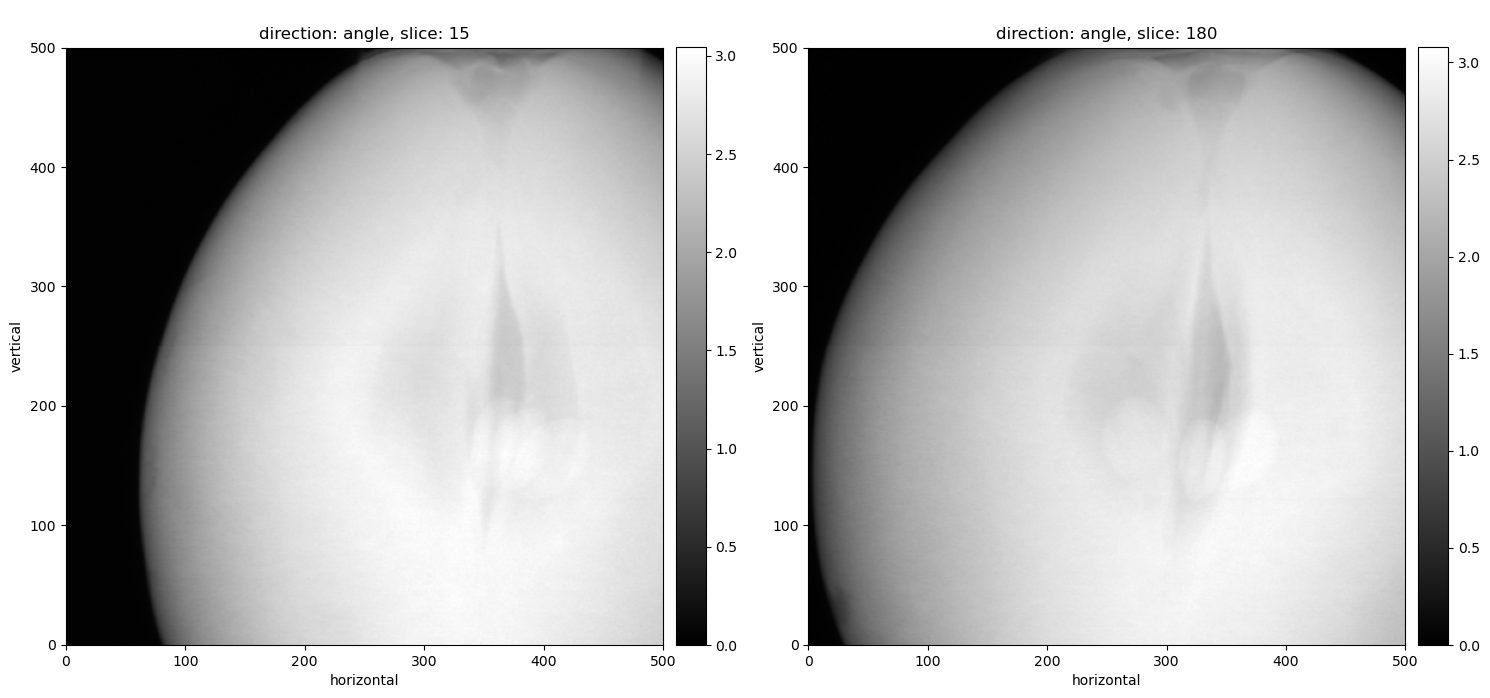

In [40]:
show2D(data, slice_list=[15, 180])

## FBP Reconstruction

We start by using the FBP reconstruction. 

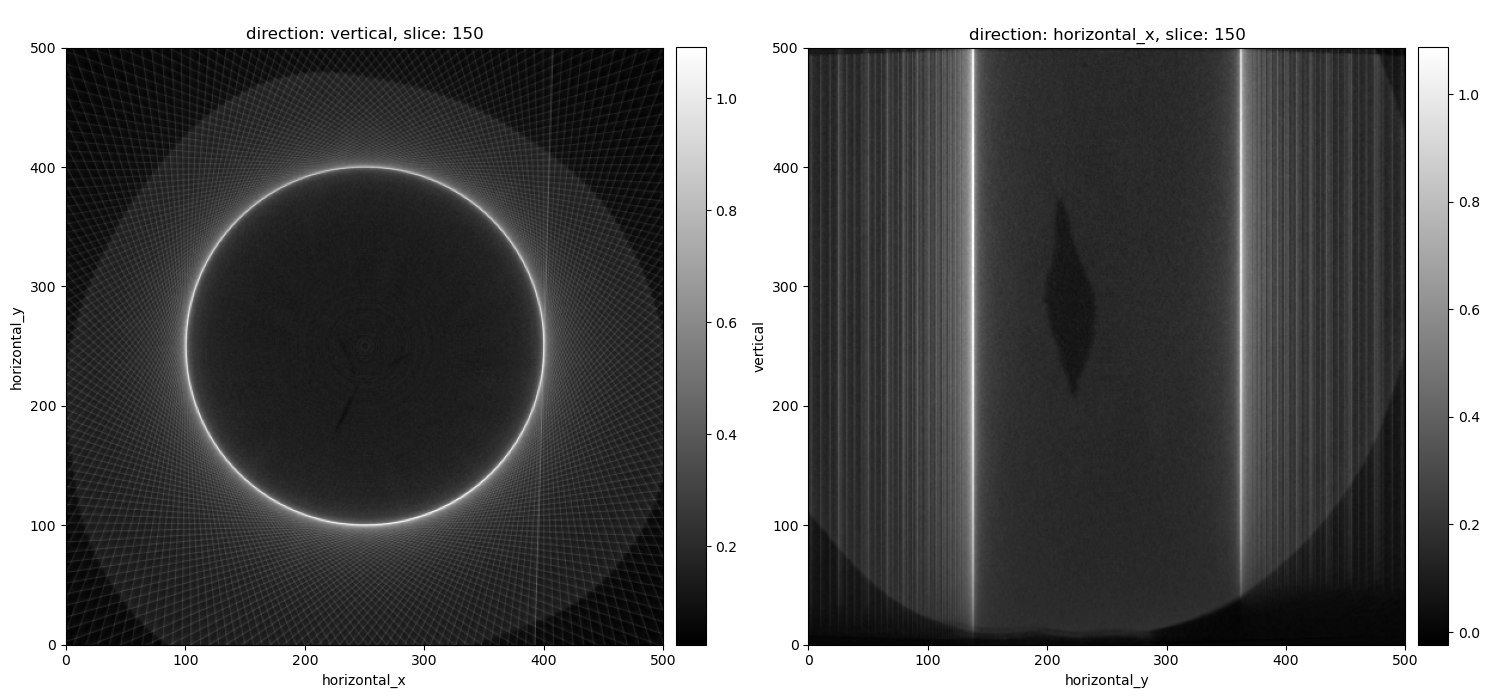

In [41]:
data.reorder(order='astra')
ig = data.geometry.get_ImageGeometry() 
fbp =  FBP(ig, data.geometry, "gpu")
recon = fbp(data)
N_slice = 150
show2D(recon, slice_list=[('vertical',N_slice), ('horizontal_x', N_slice)])

There is a very clear region-of-interest artifact so we choose to pad the projections to get it away from the sample.

In [42]:
# Padding the data
Npad = 300
data = Padder(pad_width=Npad, mode='edge')(data) # Padding in both x and y

In [43]:
data.reorder(order='astra') # Change the order of the variables in the array

ig = ImageGeometry(700, 700, 700, pixel_size, pixel_size, pixel_size) 


In [44]:
fbp =  FBP(ig, data.geometry, "gpu")
recon = fbp(data)

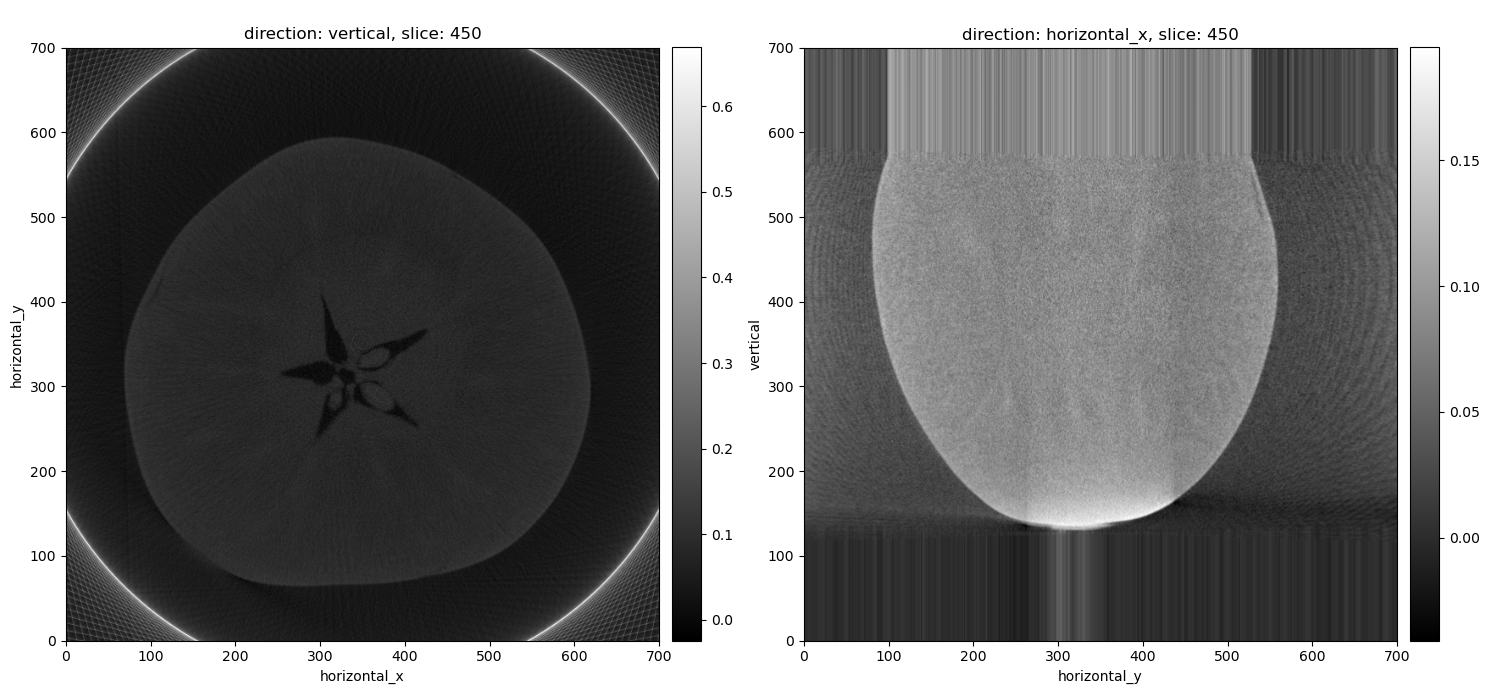

In [45]:
N_slice = 150 +Npad
show2D(recon, slice_list=[('vertical',N_slice), ('horizontal_x', N_slice)])

## Gradient descent reconstruction

Reconstruct using the gradient descent algorithm. 

In [46]:
data.reorder(order='astra') # Change the order of the variables in the array
ag = data.geometry
#ig = data.geometry.get_ImageGeometry() # save image geometry
ig = ImageGeometry(700, 700, 700, pixel_size, pixel_size, pixel_size)
b = data # Give it new name, so we have the same notation as the equations in Jacob's slides

# Set up linear operator representing forward and backward projections
A = ProjectionOperator(ig, ag, device="gpu")

In [47]:
f1 = LeastSquares(A, b) # Set up least squares problem
x0 = ig.allocate(0.0) # Start from image no. 0

# Set up gradient descent algorithm
myGD_LS = GD(initial=x0, 
             objective_function=f1, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=5)

Number of dimensions: 3
Shape: (700, 700, 700)
Axis labels: ('vertical', 'horizontal_y', 'horizontal_x')



In [48]:
myGD_LS.run(50, verbose=1) # run gradient descent algorithm

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          7.00431e+08
        1       1000       149.099          2.67866e+08
        2       1000        81.483          2.30031e+08
        3       1000        58.914          2.24150e+08
        4       1000        47.631          2.22080e+08
        5       1000        40.852          2.20706e+08
        6       1000        36.350          2.19694e+08
        7       1000        33.132          2.18896e+08
        8       1000        30.718          2.18235e+08
        9       1000        28.835          2.17678e+08
       10       1000        27.329          2.17203e+08
       11       1000        26.095          2.16794e+08
       12       1000        25.070          2.16442e+08
       13       1000        24.200          2.16139e+08
       14       1000        23.454          2.15875e+08
       15       1000        22.803          2.15

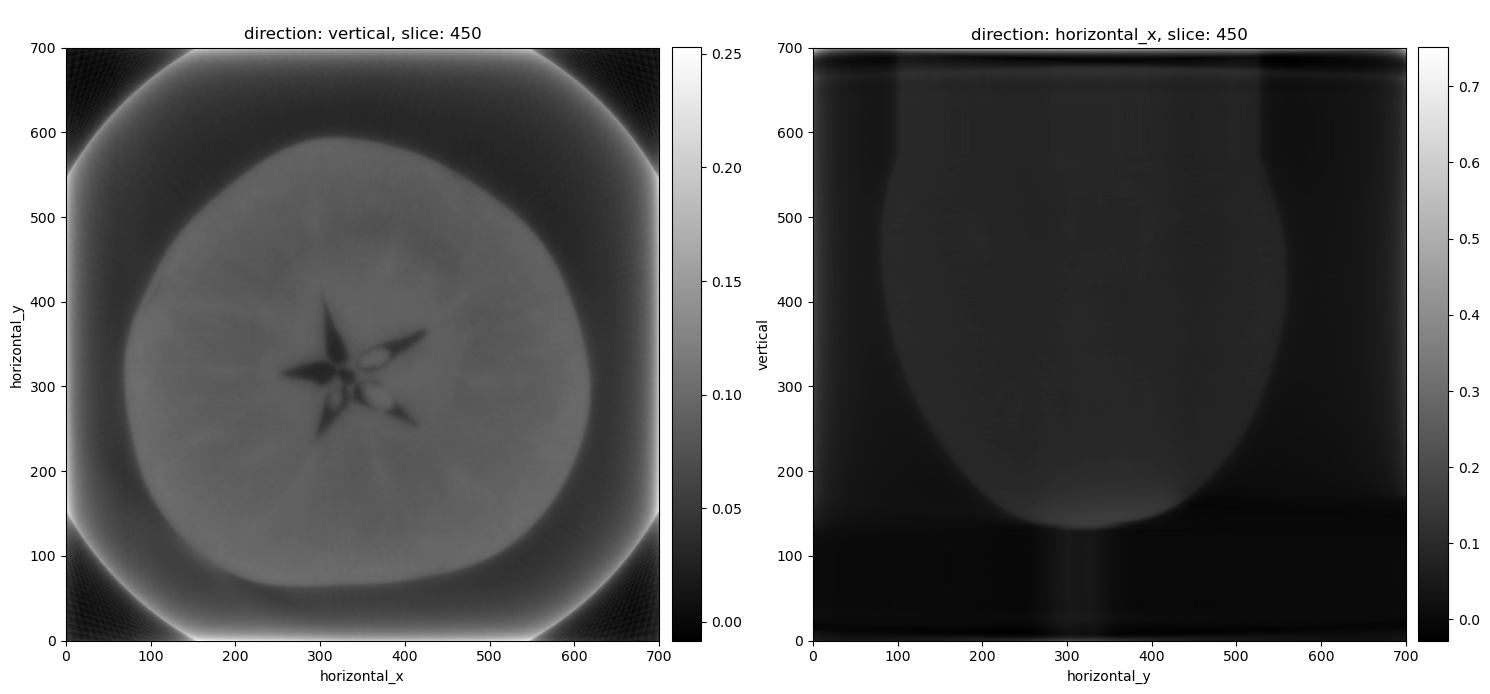

In [49]:
N_slice = 150+Npad
show2D(myGD_LS.solution, slice_list=[('vertical',N_slice), ('horizontal_x', N_slice)])

## FISTA algorithm with TV 

Reconstruct using the FISTA algorithm with TV regularisation

In [58]:
alpha=0.05
f1 = LeastSquares(A, b) # Set up least squares problem
TV = alpha*TotalVariation( lower=0)
x0 = ig.allocate(0.0)

# Set up FISTA algorithm
myFISTANN = FISTA(
    f=f1,
    g=TV,
    initial=x0,
    max_iteration=100,
    update_objective_internal=10
)

In [59]:
myFISTANN.run(100, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          7.00431e+08


In [ ]:
show2D(myFISTANN.solution, slice_list=[('vertical', 150+Npad), ('horizontal_x', 150+Npad)])